In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
import matplotlib.image as image

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assessements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)



,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
17323,00004651_000.png,No Finding,0,4651,22,M,PA,2500,2048,0.171,0.171,NaN
102299,00027236_000.png,Infiltration,0,27236,66,M,PA,3056,2544,0.139,0.139,NaN
72244,00017787_000.png,No Finding,0,17787,34,F,PA,2774,2991,0.143,0.143,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1832,00009643_000.png,No Finding,0,9643,066Y,F,PA,2500,2048,0.168,0.168
4673,00023487_008.png,No Finding,8,23487,057Y,M,PA,2858,2991,0.143,0.143
4388,00021648_006.png,No Finding,6,21648,021Y,F,AP,3056,2544,0.139,0.139


# Exploratory Analysis

### Basic Description of All X-Ray Data

In [4]:
# look at the all_xray_df datatypes and columns
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [5]:
## look at the finding labels info
all_xray_df['Finding Labels'].describe()

count         112120
unique           836
top       No Finding
freq           60361
Name: Finding Labels, dtype: object

### Summary of the Finding Labels Column
#### There are 836 unique labels for Finding Labels.

#### No Finding being the most common.

Take a look at how many in the dataset are No Finding vs a disease found.

### How many rows have a disease

In [6]:
# count rows not No Finding
disease_count = len(all_xray_df[all_xray_df['Finding Labels'] != 'No Finding'])
disease_percent = 100* disease_count / len(all_xray_df)
print(f'There are {disease_count} images with a disease present')
print('This means the disease images make up {0:.2f}% of the data'.format(disease_percent))

There are 51759 images with a disease present
This means the disease images make up 46.16% of the data


#### 51759 rows have a disease found

## One-Hot Encode No Finding

In [7]:
# create a column of Findings is 1 and No Findings is 0
all_xray_df['Findings'] = all_xray_df['Finding Labels'].apply(lambda x: 1 if x != 'No Finding' else 0)
all_xray_df.head()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Findings
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,1
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,1
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,1
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,1


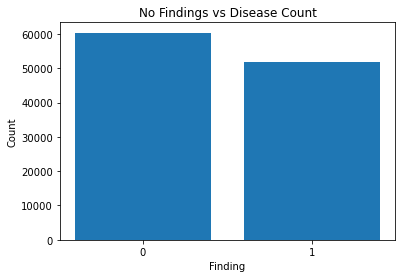

In [8]:
# plot a bar chart of the disease vs non-disease findings
plt.bar([0,1], all_xray_df['Findings'].value_counts())
plt.xlabel('Finding')
plt.ylabel('Count')
plt.title('No Findings vs Disease Count')
plt.xticks([0,1])
plt.show()

In [9]:
all_xray_df['Findings'].value_counts()

0    60361
1    51759
Name: Findings, dtype: int64

There are **60361 rows of No Finding** and **51759 rows of a disease found.**

This is fairly balanced for between the two categories. I wonder what the usual distribution of patients getting a chest x-ray in a doctor's office is. That would be the optimal distribution for this dataset.


### Look at the Number of Images with Only Pneumonia

In [10]:
len(all_xray_df[all_xray_df['Finding Labels'] == 'Pneumonia'])

322

There are 322 rows of data where pneumonia with no codiseases has been found. Next look for all rows with pneumonia plus other diseases.

In [11]:
import re

In [12]:
# create the regular expression to find all the pneumonia labels
regex = re.compile(r'[A-Za-z|]*Pneumonia[A-Za-z|]*')

# create a list for storing the index values with pneumonia
idx_list = []

# iterate through all the rows of the dataframe
for idx, row in all_xray_df.iterrows():
    # look for pneumonia in the Finding Labels
    pneum = regex.findall(row['Finding Labels'])
    if len(pneum) > 0:
        idx_list.append(idx)
    
        

In [13]:
# check how many rows have pneumonia
print('Number of rows with Pneumonia:', len(idx_list))
print('Percent of rows with Pneumonia: {0:.2f}%'.format(100 * len(idx_list)/len(all_xray_df)))

Number of rows with Pneumonia: 1431
Percent of rows with Pneumonia: 1.28%


#### There are 1431 cases of pneumonia, including codisease, spotted in the dataset which accounts for 1.28% of the dataset.

This is a very low percentage and will mean that the training dataset will need to be carefully selected to give the model a balanced set of pneumonia and non-pneumonia images.

**Strategies for Dealing with Imbalanced Pneumonia Count:** 

1. One strategy is to simply take 80% of the pneumonia rows and an equal number of non-pneumonia rows for th training. Then use the remaining 20% of pneumonia rows as the testing data which can be more similarly propotioned to real life distributions. This would eliminate a significant portion of the non-pneumonia data from the training of the model, though 1145 positive pneumonia images may be sufficient.

2. A second strategy is to do bagging and take the 80% of pneumonia rows and increase it through resampling and replacement to match 50% of the total of 80% of the total dataset rows ( 112120*0.8 = 89696 ) meaning the pneumonia training data would have to go from  1145 to 44848. That seems like it might be too much resampling of the positive pneumonia data.

In [14]:
# create a dataframe of pneumonia + codiseases
pneumonia_df = all_xray_df.iloc[idx_list, :]

# create an index of non-pneumonia
no_pneum_idx = all_xray_df.index.drop(idx_list)
# create a dataframe of no pneumonia
no_pneumonia_df = all_xray_df.iloc[no_pneum_idx, :]

len(no_pneumonia_df), len(pneumonia_df)

(110689, 1431)

# Patient Demographics

## Gender

In [15]:
# look at gender distribution
gender_count = all_xray_df['Patient Gender'].value_counts()
print(gender_count)

M    63340
F    48780
Name: Patient Gender, dtype: int64


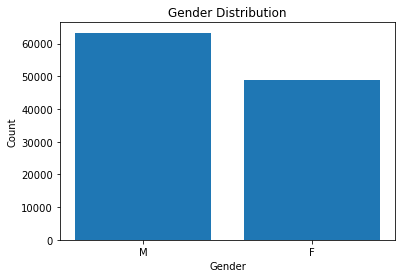

In [16]:
# plot the gender distribution
plt.bar(gender_count.index, gender_count)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### The gender distribution is slightly overrepresented by Male. This can be brought to an equal distribution for the training dataset and would be something to be mindful of.

## View the Gender distribution of pneumonia data

In [17]:
# view the distribution of genders with pneumonia
gender_pn_count = pneumonia_df['Patient Gender'].value_counts()
print(gender_pn_count)

M    838
F    593
Name: Patient Gender, dtype: int64


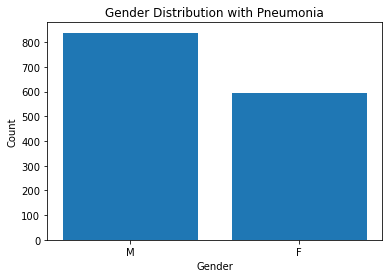

In [18]:
# plot the gender distribution with pneumonia
plt.bar(gender_pn_count.index, gender_pn_count)
plt.title('Gender Distribution with Pneumonia')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### Analysis of Gender Distribution with Pneumonia:
#### Very similar to the Gender distribution of the entire dataset. This means that even within the positive pneumonia training dataset, the gender distribution will have to be manipulated to equal distribution.

## Age Distribution

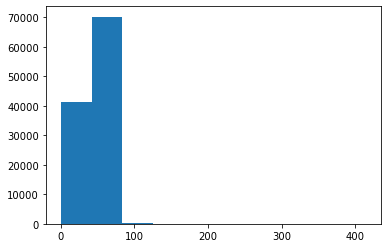

In [19]:
# create a histogram of the patient ages
plt.hist(all_xray_df['Patient Age'])
plt.show()

#### This is not what was expected. Check for the range of values because it appears there are some very large age values.

In [20]:
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

#### There is some incorrect data in this dataset. 

## View the data that has a patient age above 100

In [21]:
# view the number of patients above 100 for patient age
all_xray_df['Patient Age'][all_xray_df['Patient Age'] > 100]

20852     412
46965     414
48284     148
55742     148
58650     150
62929     149
74884     152
78795     151
84810     411
85404     412
86264     413
91369     412
95794     153
98495     154
101194    155
104590    155
Name: Patient Age, dtype: int64

#### This is a very small amount of data and can probably be dropped. I do want to check if these are in the pneumonia or non-pneumonia category since the pneumonia data is already small it would not be wise to discard data.

In [22]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Findings'],
      dtype='object')

In [23]:
# view patient age above 100 and whether no_finding is there
large_age = all_xray_df['Findings'][all_xray_df['Patient Age'] > 100].value_counts()
large_age

1    8
0    8
Name: Findings, dtype: int64

In [24]:
# check how many of incorrect Age values are from pneumonia images
pneum_large_age = len(pneumonia_df[pneumonia_df['Patient Age'] > 100])
print(f'There is {pneum_large_age} image with Age value above 100')

There is 1 image with Age value above 100


In [25]:
percent_above_100 = 100 * sum(large_age) / len(all_xray_df)
print('The percent of data that is out of range for age is {0:.2f}% of the total data'.format(percent_above_100))

The percent of data that is out of range for age is 0.01% of the total data


#### The incorrect age data has an equal split between Findings and No Findings. 

#### As well, this data represents only 0.01% of all the data. 

#### Only one of the pneumonia images has Age above 100, so dropping it does not have a major impact on the model.

## Remove the rows with Age above 100

In [26]:
# drop the rows with age over 100
all_xray_df = all_xray_df[all_xray_df['Patient Age'] <= 100]

In [27]:
# do the same for the pneumonia and non-pneumonia dfs 
pneumonia_df = pneumonia_df[pneumonia_df['Patient Age'] <= 100]
no_pneumonia_df = no_pneumonia_df[no_pneumonia_df['Patient Age'] <= 100]

In [28]:
# view the min and max of age
age_min = all_xray_df['Patient Age'].min()
age_max = all_xray_df['Patient Age'].max()

print(f'The min age in the dataframe is {age_min}')
print(f'The max age in the dataframe is {age_max}')

The min age in the dataframe is 1
The max age in the dataframe is 95


### View the Age Distribution after Dropping

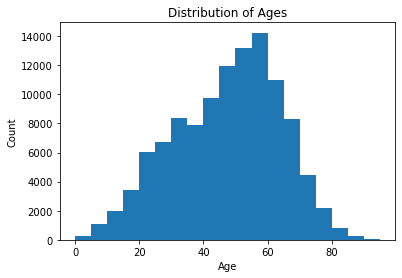

In [29]:
# create bins of 5 years
age_bins = list(range(0,100,5))

# view a histogram of the ages
plt.hist(all_xray_df['Patient Age'], bins=age_bins)
plt.title('Distribution of Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### The age distribution is almost a normal distribution. It has a slight left skew.

## View the Age Distribution of the Pneumonia data

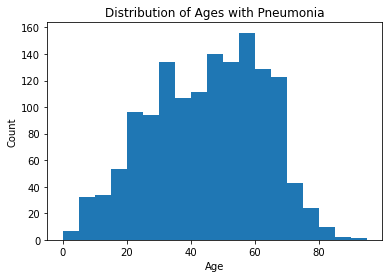

In [30]:
# histogram of pneumonia data ages
plt.hist(pneumonia_df['Patient Age'], bins=age_bins)
plt.title('Distribution of Ages with Pneumonia')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### This age distribution looks very close to a normal distribution and the age for the training dataset when randomly selected should represent that.

As well, this gives a look at the age range for the Intended Use of the technology, which is ages 1 to 95.

# View Position Distribution

Look at the distribution of View Position to know if it needs to systematically sampled for training

In [31]:
# get the value count for each position
view_pos_counts = all_xray_df['View Position'].value_counts()
print(view_pos_counts)

PA    67299
AP    44805
Name: View Position, dtype: int64


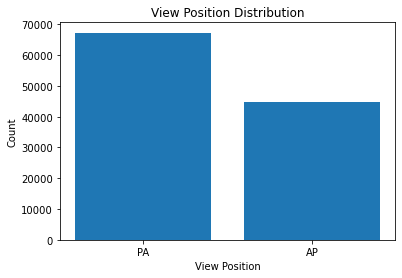

In [32]:
# plot a bar chart
plt.bar(view_pos_counts.index, view_pos_counts)
plt.title('View Position Distribution')
plt.xlabel('View Position')
plt.ylabel('Count')
plt.show()

#### There are far more PA images than AP images. This distribution will have to be set to a balanced distribution for the training dataset. Let's view whether the View Position is similarly distributed amongst the pneumonia cases.

## View Position Distribution for Pneumonia Images

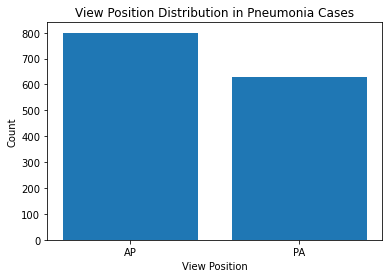

In [33]:
# value count of View Position for the dataset with positive pneumonia
pneum_view_counts = pneumonia_df['View Position'].value_counts() 

# plot a bar chart
plt.bar(pneum_view_counts.index, pneum_view_counts)
plt.title('View Position Distribution in Pneumonia Cases')
plt.xlabel('View Position')
plt.ylabel('Count')
plt.show()

#### This shows that is slightly more even amongst the positive pneumonia images. That means it will need less selective sampling of data to get a balanced dataset of training data for images with pneumonia. 

Oddly enough, AP is higher distribution in the pneumonia cases but lower in the overall dataset distribution. This is not what was expected and could be investigated to know whether there is **rational for choosing AP if a doctor thinks their patient has pneumonia.**

# View the distribution of Co-Disease with Pneumonia

### Show the number of different disease combinations

In [34]:
# create a value count of the Finding Labels in the pneumonia dataframe
finding_counts = pneumonia_df['Finding Labels'].value_counts()

# check how many unique combinations there are
len(finding_counts)

142

### 142 different combinations of pneumonia with other diseases.
This is too many to visually look at. Instead, look at the top 20 

In [35]:
# select only the 20 most frequent pneumonia with other disease
top_20 = finding_counts[:20]
print(top_20)

Pneumonia                                      322
Infiltration|Pneumonia                         199
Edema|Infiltration|Pneumonia                   137
Atelectasis|Pneumonia                          108
Edema|Pneumonia                                 83
Effusion|Pneumonia                              53
Effusion|Infiltration|Pneumonia                 42
Consolidation|Pneumonia                         36
Atelectasis|Infiltration|Pneumonia              34
Atelectasis|Effusion|Pneumonia                  23
Edema|Effusion|Infiltration|Pneumonia           21
Edema|Effusion|Pneumonia                        19
Nodule|Pneumonia                                19
Atelectasis|Effusion|Infiltration|Pneumonia     18
Atelectasis|Consolidation|Pneumonia             15
Consolidation|Infiltration|Pneumonia            13
Infiltration|Nodule|Pneumonia                   11
Mass|Pneumonia                                  11
Pleural_Thickening|Pneumonia                    11
Consolidation|Effusion|Pneumoni

#### Pneumonia alone is the largest count. 

#### The co-disease large counts are for Infiltration, Edema, Atelectasis, Effusion, and Consolidation

What does this mean for selecting data for the model? Well, **the majority of the positive pneumonia cases will have a co-disease** and most of those will come from the large count cases. This means that **Infiltration, Edema, Atelactasis, Effusion and Consolidation will be highly represented** if simply randomly selected.

One strategy is to make sure some of the under-represented co-diseases are resampled in the training data to allow the model to accurately learn these rare cases. Although, since our model is only **assisting a radiologist**, it may not need to be as accurate on the rare cases and those rare cases can be the ones where the radiologist spends more time analyzing. **If the model is helpful it majority of cases, by reducing time spent on analysis, then it has done its job and can leave the radiologist for more time to analyze the rare cases.**

## Number of Diseases per Patient

In [36]:
# create a list for storing the disease count
count_list = []

# iterate through all the rows of the dataframe
for idx, row in all_xray_df.iterrows():
    # look for diseases in the Finding Labels
    pneum = row['Finding Labels'].split('|')
    
    if len(pneum) == 1 and pneum[0] != 'No Finding':
        count = 1
    elif pneum[0] == 'No Finding':
        count = 0
    elif len(pneum) > 1:
        count = len(pneum)

        
    # append the disease count to the list
    count_list.append(count)

# check that the disease count list is as long as the dataframe    
len(count_list), len(all_xray_df)

(112104, 112104)

In [37]:
# add the column of disease count to the dataframe
dis_count = pd.DataFrame(count_list, columns=['Disease Count'])
all_xray_df = pd.concat([all_xray_df, dis_count], axis=1)
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Findings,Disease Count
0,00000001_000.png,Cardiomegaly,0.0,1.0,58.0,M,PA,2682.0,2749.0,0.143,0.143,NaN,1.0,1.0
1,00000001_001.png,Cardiomegaly|Emphysema,1.0,1.0,58.0,M,PA,2894.0,2729.0,0.143,0.143,NaN,1.0,2.0
2,00000001_002.png,Cardiomegaly|Effusion,2.0,1.0,58.0,M,PA,2500.0,2048.0,0.168,0.168,NaN,1.0,2.0
3,00000002_000.png,No Finding,0.0,2.0,81.0,M,PA,2500.0,2048.0,0.171,0.171,NaN,0.0,0.0
4,00000003_000.png,Hernia,0.0,3.0,81.0,F,PA,2582.0,2991.0,0.143,0.143,NaN,1.0,1.0


### Plot the Number of Disease Findings per Image

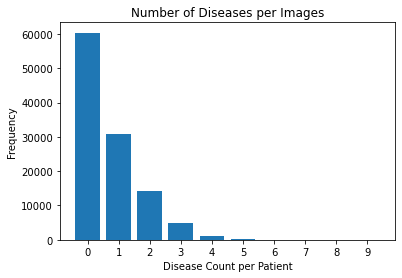

In [38]:
# plot a bar plot of the disease count frequencies
disease_counts = all_xray_df['Disease Count'].value_counts()
plt.bar(disease_counts.index, disease_counts)
plt.xlabel('Disease Count per Patient')
plt.ylabel('Frequency')
plt.xticks(list(range(10)))
plt.title('Number of Diseases per Images')
plt.show()

In [39]:
# view the value counts
disease_counts

0.0    60353
1.0    30959
2.0    14302
3.0     4856
4.0     1247
5.0      301
6.0       67
7.0       16
9.0        2
8.0        1
Name: Disease Count, dtype: int64

### Plot the Number of Disease Findings per Image (minimum 1 disease)

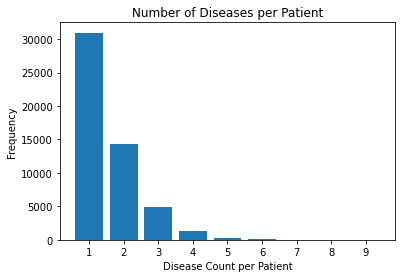

In [40]:
# plot without the 0 values
plt.bar(disease_counts.index[1:], disease_counts[1:])
plt.xlabel('Disease Count per Patient')
plt.ylabel('Frequency')
plt.xticks(list(range(1,10)))
plt.title('Number of Diseases per Patient')
plt.show()

#### The majority of the data either has No Findings or has one, two, or three diseases. Very little of the data has more than three diseases.

For the modeling, it will important to try to train the model on a variety of disease combinations but since there is a majority of images with three or fewer diseases, the four or more diseases will be underrepresented. This presents an issue for our use case. The limitations of the model will be exposed after training, but the number of multiple diseases present may be a limitation and should be kept in mind while evaluating the models trained later. 

# Pixel Intensity Analysis

Use sample_df to look at the pixel intensities

In [41]:
# create a function to create a file path for each image
def image_path(df):
    filepath = None
    image = df['Image Index']
    for num in range(12):
        name = 'images_' + str(num).zfill(3)
        file_name = '/data/' + name + '/images/' + image
        if os.path.isfile(file_name):
            filepath = file_name
            break
    return filepath

In [42]:
# apply the function to the dataframe
sample_df['Image_Path'] = sample_df.apply(image_path, axis=1)
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Image_Path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000032_001.png


In [43]:
# create a list of diseases
diseases = []

# split the Findings and create a list of unique findings
for name in sample_df['Finding Labels']:
    findings = name.split('|')
    for dis in findings:
        if dis not in diseases:
            diseases.append(dis)
    
diseases

['Emphysema',
 'Infiltration',
 'Pleural_Thickening',
 'Pneumothorax',
 'Cardiomegaly',
 'No Finding',
 'Atelectasis',
 'Edema',
 'Effusion',
 'Consolidation',
 'Mass',
 'Nodule',
 'Fibrosis',
 'Pneumonia',
 'Hernia']

## One-Hot Encode the Disease Findings

In [44]:
# create dataframe to count diseases
disease_df = pd.DataFrame(columns=diseases)

# iterate through the sample_df and one-hot encode the disease_df
for idx, row in sample_df.iterrows():
    name = sample_df.loc[idx, 'Finding Labels']
    findings = name.split('|')
    # make every column equal to 0
    disease_df.loc[idx, :] = 0
    # add a 1 in columns where in findings
    disease_df.loc[idx, findings] = 1
    

In [45]:
disease_df.head()

,Emphysema,Infiltration,Pleural_Thickening,Pneumothorax,Cardiomegaly,No Finding,Atelectasis,Edema,Effusion,Consolidation,Mass,Nodule,Fibrosis,Pneumonia,Hernia
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0


In [46]:
# concatenate the dataframes
sample_df = pd.concat([sample_df, disease_df], axis=1)
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,No Finding,Atelectasis,Edema,Effusion,Consolidation,Mass,Nodule,Fibrosis,Pneumonia,Hernia
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,1,0,0,0,0,0,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0,1,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0,0,1,1,0,0,0,0,0,0


## View Pneumonia Examples

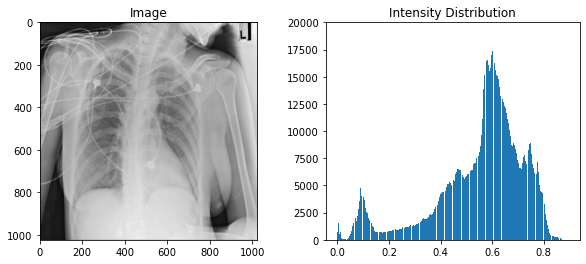

In [47]:
# find examples with only pneumonia as a finding
pneumonia_examples = sample_df[sample_df['Finding Labels'] == 'Pneumonia']


def show_image_distr(img_data):
    f = plt.figure()
    f.set_figwidth(10)

    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')


    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    # limit the y-range to avoid any background spikes from distorting the view
    plt.ylim(0, 20000)
    plt.hist(img_data.ravel(), bins = 256)

    plt.show()

    

# get the first pneumonia only example
pneumonia_example_1 = pneumonia_examples.iloc[0, :]
ex1_data = image.imread(pneumonia_example_1['Image_Path'])
show_image_distr(ex1_data)


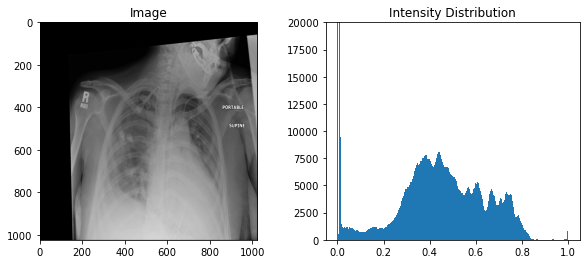

In [48]:
# get the second pneumonia image and view it
pneumonia_example_2 = pneumonia_examples.iloc[1, :]
ex2_data = image.imread(pneumonia_example_2['Image_Path'])
show_image_distr(ex2_data)

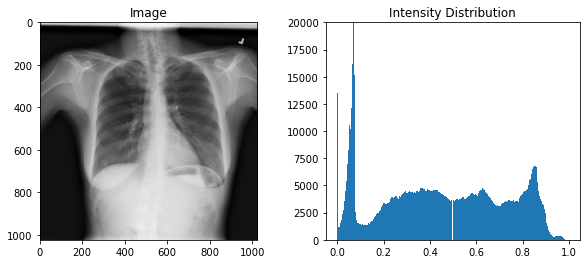

In [49]:
# get the third pneumonia example and view it
pneumonia_example_3 = pneumonia_examples.iloc[2, :]
ex3_data = image.imread(pneumonia_example_3['Image_Path'])
show_image_distr(ex3_data)

## View  No Finding Examples

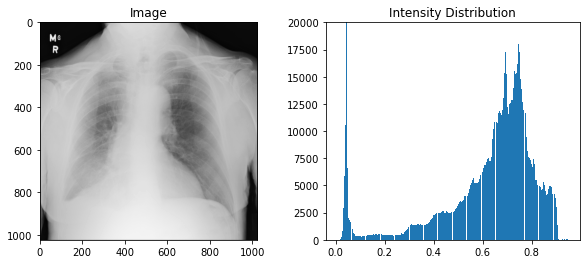

In [50]:
# get the first example of No Finding and view it
no_finding_example_1 = sample_df[sample_df['No Finding'] == 1].iloc[0, :]
no_find_1 = image.imread(no_finding_example_1['Image_Path'])
show_image_distr(no_find_1)

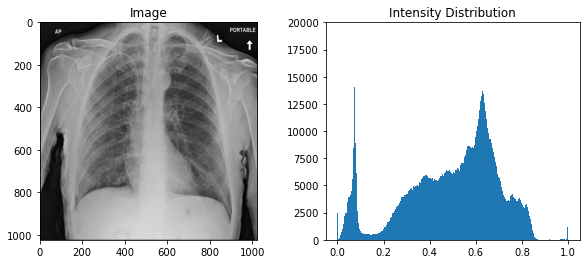

In [51]:
# get the second No Finding example and view it
no_finding_example_2 = sample_df[sample_df['No Finding'] == 1].iloc[1, :]
no_find_2 = image.imread(no_finding_example_2['Image_Path'])
show_image_distr(no_find_2)

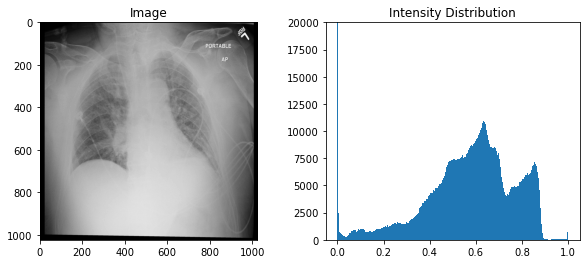

In [52]:
# get the third No Finding example and view it
no_finding_example_3 = sample_df[sample_df['No Finding'] == 1].iloc[2, :]
no_find_3 = image.imread(no_finding_example_3['Image_Path'])
show_image_distr(no_find_3)

## Compare Intensity Distributions from Multiple Diseases

In [53]:
# create a function to show the pixel intensities
def show_image_distr(img_data):
    plt.figure(figsize=(5,5))
    
    plt.title('Intensity Distribution')
    plt.ylim(0, 20000)
    plt.hist(img_data.ravel(), bins = 256)

    plt.show()

### View Infiltration & Pneumonia Image Pixel Intensities

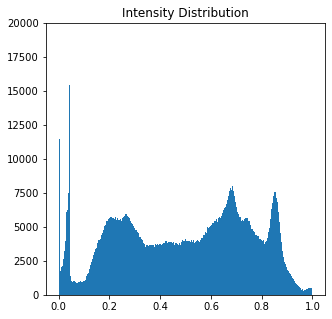

In [54]:
# find rows with Infiltration and Pneumonia
infiltration_pneum = sample_df[sample_df['Finding Labels'] == 'Infiltration|Pneumonia']

# choose the first image
inf_pneum_example_1 = infiltration_pneum.iloc[0, :]
# get the image path
inf_pneum_1 = image.imread(inf_pneum_example_1['Image_Path'])

show_image_distr(inf_pneum_1)


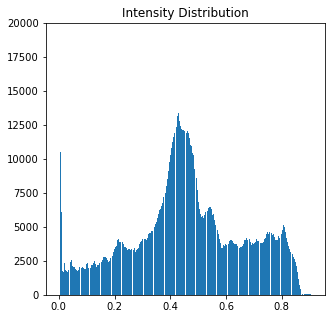

In [55]:
# choose the first image
inf_pneum_example_2 = infiltration_pneum.iloc[1, :]
# get the image path
inf_pneum_2 = image.imread(inf_pneum_example_2['Image_Path'])

show_image_distr(inf_pneum_2)

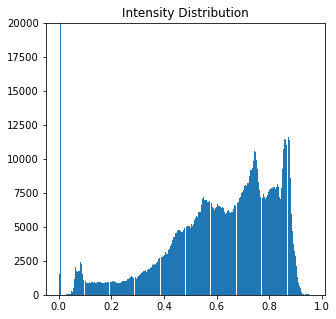

In [56]:
# choose the first image
inf_pneum_example_3 = infiltration_pneum.iloc[2, :]
# get the image path
inf_pneum_3 = image.imread(inf_pneum_example_3['Image_Path'])

show_image_distr(inf_pneum_3)

## Filter out the Background Pixels
There is a large spike of pixels around 0.0 value which is the value for the color black.

This background pixel intensity can be removed from the pixel intensities to make for a clear view of the pixel intensities and easier comparison.

In [57]:
# create a mask function to filter the pixels
def mask_func(x, back_thresh=0.1):
    if x > back_thresh:
        return 1.0
    else:
        return 0.0
    
# create a list for storing the filter pixels   
mask_image = list()

# iterate through the arrays and append filtered pixels
for ls in inf_pneum_3:
    mask_array = list(map(mask_func, ls))
    mask_image.append(mask_array)

# convert to a numpy array
mask_image = np.array(mask_image)
mask_image.shape

(1024, 1024)

### View the Image of the Mask at Threshold 0.1

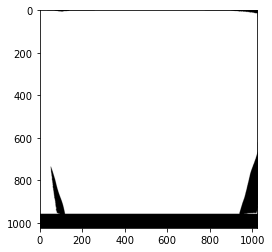

In [58]:
plt.imshow(mask_image, cmap='gray')

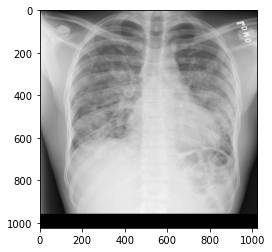

In [59]:
plt.imshow(inf_pneum_3, cmap='gray')

### Background threshold cutoff of 0.1 seems too cut-out too much of the actual body xray. Adjust to try 0.2 cutoff instead

In [60]:
# create a mask function to filter the pixels
def mask_func(x, back_thresh=0.2):
    if x > back_thresh:
        return 1.0
    else:
        return 0.0
    
# create a list for storing the filter pixels   
mask_image = list()

# iterate through the arrays and append filtered pixels
for ls in inf_pneum_3:
    mask_array = list(map(mask_func, ls))
    mask_image.append(mask_array)

# convert to a numpy array
mask_image = np.array(mask_image)
mask_image.shape

(1024, 1024)

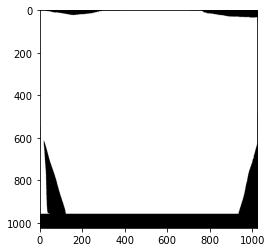

In [61]:
plt.imshow(mask_image, cmap='gray')

### The threshold of 0.2 for the pixels is much better at narrowing down to just the region of interest.

For pixel intensity plots, remove the pixels less than or equal to 0.2

In [62]:
# create a function for removing the pixel intensities below 0.2 
def filter_pixels(df_row):
    # get the image path
    image_data = image.imread(df_row['Image_Path'])
    # remove the values lesser than or equal to 0.2
    ravel_img = image_data.ravel()
    # cut out background pixels
    cutoff_data = ravel_img[ravel_img > 0.2]
    # cut out excessivel bright foreground
    cutoff_data = cutoff_data[cutoff_data < 0.95]
    
    return cutoff_data
    
    

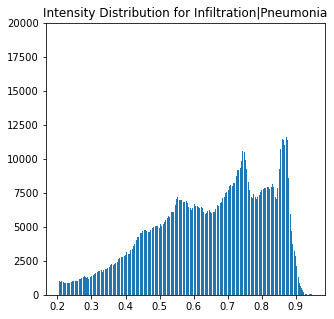

In [63]:
# test the function
cutoff_data = filter_pixels(inf_pneum_example_3)

# get finding label value
find_value = inf_pneum_example_3['Finding Labels']
    
plt.figure(figsize=(5,5))
    
plt.title(f'Intensity Distribution for {find_value}')
plt.ylim(0, 20000)
plt.hist(cutoff_data, bins = 256)

plt.show()

## Compare Pixel Intensity Averages across different diseases

Take 20 images from the different diseases and average the pixel intensities and plot them.

Compare the distributions to get some insights into which disease may confuse for pneumonia using this technique.

In [64]:
# get a list of the unique diseases
unique_list = []
for disease in sample_df['Finding Labels']:
    split_dis = disease.split('|')
    for name in split_dis:
        if name not in unique_list:
            unique_list.append(name)

# get the value_counts for when the disease is found uniquely
value_counts = sample_df['Finding Labels'].value_counts()
# use the unique list to return only single disease names
single_dis_counts = value_counts[unique_list].sort_values(ascending=False)
single_dis_counts

No Finding            3044
Infiltration           503
Effusion               203
Atelectasis            192
Nodule                 144
Pneumothorax           114
Mass                    99
Consolidation           72
Pleural_Thickening      65
Cardiomegaly            50
Emphysema               42
Edema                   41
Fibrosis                38
Pneumonia               14
Hernia                   5
Name: Finding Labels, dtype: int64

### For all but Pneumonia and Hernia, we can take 30 or more images and average the pixel intensities to get a pixel intensity profile of each disease

## Create a Pixel Intensity Distribution profile for Each Disease

In [65]:
# isolate only the single disease Finding Labels
single_finding_labels = sample_df[sample_df['Finding Labels'].isin(unique_list)]
single_finding_labels.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,No Finding,Atelectasis,Edema,Effusion,Consolidation,Mass,Nodule,Fibrosis,Pneumonia,Hernia
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,1,0,0,0,0,0,0,0,0,0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0,1,0,0,0,0,0,0,0,0
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,...,1,0,0,0,0,0,0,0,0,0
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,...,1,0,0,0,0,0,0,0,0,0
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,...,0,0,0,1,0,0,0,0,0,0


In [66]:
# shuffle the dataframe to make the chosen rows random
single_finding_labels = single_finding_labels.sample(frac=1.0).reset_index(drop=True)

In [67]:
# create a dictionary to store each dataframe by disease
dis_dic = {}

# for each disease take 30 rows except for pneumonia and hernia and No Finding
for disease in unique_list:
    if disease not in ['Pneumonia', 'Hernia', 'No Finding']:
        # create a dataframe of only the disease for 30 rows and store in dictionary
        dis_dic[disease] = sample_df[sample_df['Finding Labels'] == disease].iloc[:30,:]
        
# view the diseases are as expected        
dis_dic.keys()

dict_keys(['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax', 'Cardiomegaly', 'Atelectasis', 'Edema', 'Effusion', 'Consolidation', 'Mass', 'Nodule', 'Fibrosis'])

In [68]:
# create a dataframe of all the data for each, pneumonia and hernia, then add to dictionary
for disease in ['Pneumonia', 'Hernia']:
    dis_dic[disease] = sample_df[sample_df['Finding Labels'] == disease]
    
# veiw updated dicitionary
dis_dic.keys()

dict_keys(['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax', 'Cardiomegaly', 'Atelectasis', 'Edema', 'Effusion', 'Consolidation', 'Mass', 'Nodule', 'Fibrosis', 'Pneumonia', 'Hernia'])

In [69]:
# get all the pixel intensities for each disease for ploting
# create new dictionary for the unraveled disease pixels
all_dis_dic = {}

for dis in dis_dic.keys():
    disease_name = dis
    # for each dataframe filter the pixels
    dis_df = dis_dic[dis]
    
    # create an array to store the filtered pixels
    pixel_array = np.array([])
    idx = 0
    
    # iterate through all the image paths for the disease dataframe
    for img in dis_df['Image_Path']:
        try:
            img_data = image.imread(img)
            img_ravel = img_data.ravel()
            #filter the data with > 0.2 threshold
            filter_img = img_ravel[(img_ravel > 0.2)&(img_ravel < 0.95)]
            # add to the pixel array
            pixel_array = np.append(pixel_array, filter_img)
        except:
            continue
            
    all_dis_dic[dis] = pixel_array

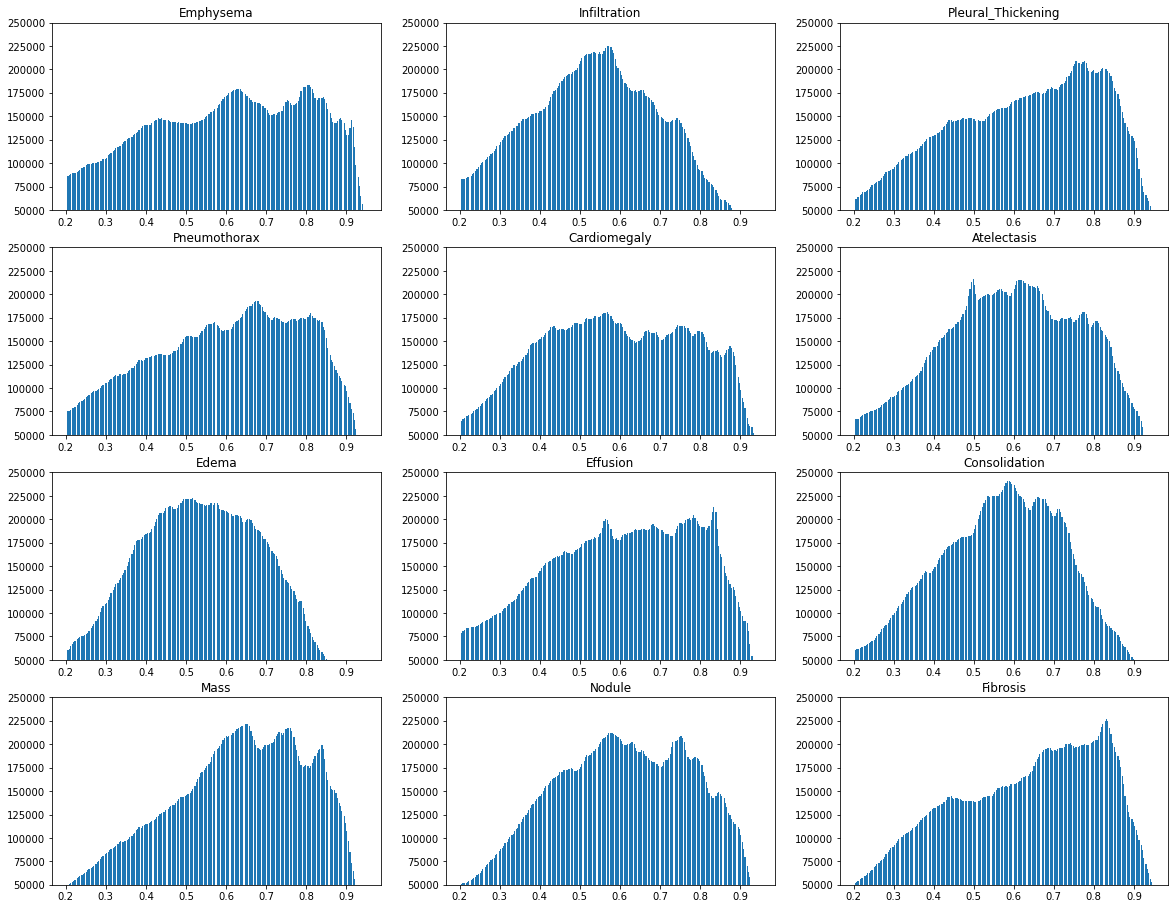

In [75]:
fig = plt.figure()
fig.set_figwidth(20)
fig.set_figheight(20)

i = 0
for disease in all_dis_dic.keys():
    # skip Pneumonia and Hernia since they have smaller count
    if disease not in ['Pneumonia', 'Hernia']:
        # set the subplot position
        sub = fig.add_subplot(5, 3, i+1)
        sub.set_title(disease)
        # plot the histogram
        plt.hist(all_dis_dic[disease], bins = 256)
        plt.ylim(50000, 250000)
        # increase the index by 1
        i += 1

        
plt.show()

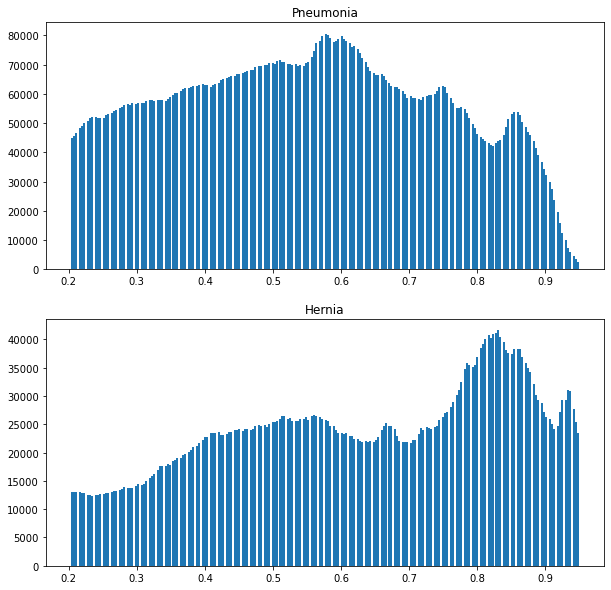

In [86]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)

i = 0
for disease in ['Pneumonia', 'Hernia']:
    # set the subplot position
    sub = fig.add_subplot(2, 1, i+1)
    sub.set_title(disease)
    # plot the histogram
    plt.hist(all_dis_dic[disease], bins = 256)
    # increase the index by 1
    i += 1

        
plt.show()

## Compare Similar Intensities

### Edema, Consolidation, and Infiltration have similar intensity plots

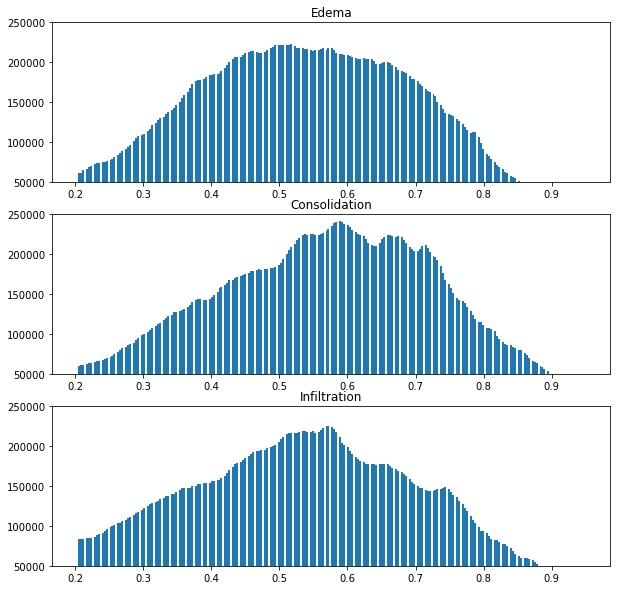

In [74]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)

i = 0
for disease in ['Edema', 'Consolidation', 'Infiltration']:
    # set the subplot position
    sub = fig.add_subplot(3, 1, i+1)
    sub.set_title(disease)
    # plot the histogram
    plt.hist(all_dis_dic[disease], bins = 256)
    plt.ylim(50000, 250000)
    # increase the index by 1
    i += 1

        
plt.show()

Upon closer inspection Infiltration and Consolidation are very close in shape with a peak around 0.55.

Edema has a wider top distribution and seems to have a slight peak around 0.45

These three diseases could cause misdiagnosis if using pixel intensity plots for diagnosis.

### Emphysema and Nodule have similar plots

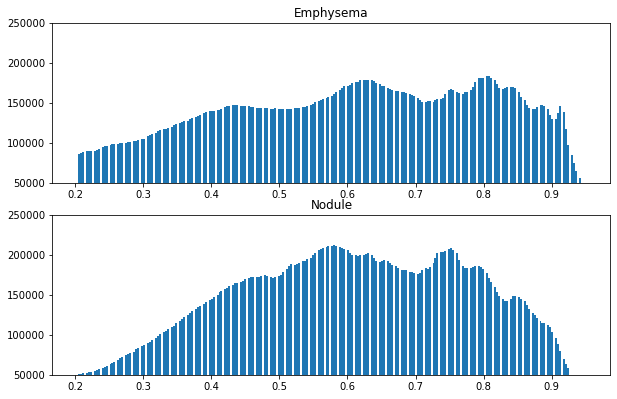

In [76]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)

i = 0
for disease in ['Emphysema', 'Nodule']:
    # set the subplot position
    sub = fig.add_subplot(3, 1, i+1)
    sub.set_title(disease)
    # plot the histogram
    plt.hist(all_dis_dic[disease], bins = 256)
    plt.ylim(50000, 250000)
    # increase the index by 1
    i += 1

        
plt.show()

Upon closer inspection, while the two disease have what looks like two peaks the alignment of the peaks is different. 

For **Emphysema**, the two peaks are around **0.62 and 0.8**

For **Nodule**, the two peaks are around **0.57 and 0.75**

This difference can allow for a distinction between the two diseases for pixel intensity plots used for diagnosis. Though if there is some decent variability, it could cause a mis-diagnosis.

### Pleural Thickening, Fibrosis, and Hernia are similar plots

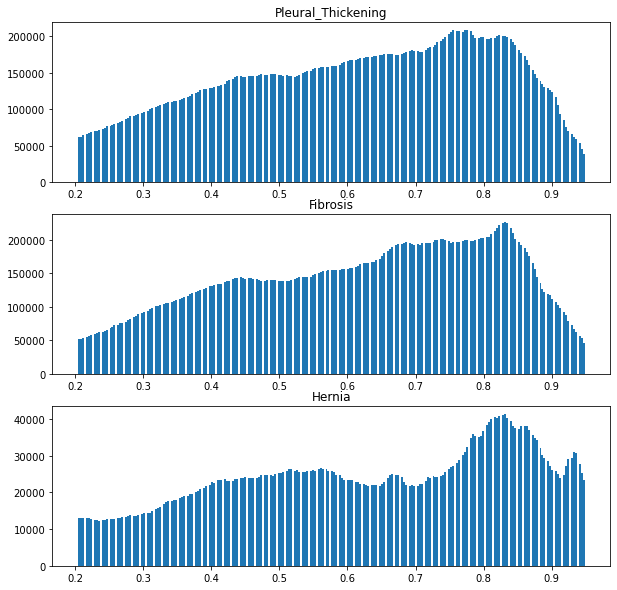

In [88]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)

i = 0
for disease in ['Pleural_Thickening', 'Fibrosis', 'Hernia']:
    # set the subplot position
    sub = fig.add_subplot(3, 1, i+1)
    sub.set_title(disease)
    # plot the histogram
    plt.hist(all_dis_dic[disease], bins = 256)
    # increase the index by 1
    i += 1

        
plt.show()

While all three intensity plots have a long tail to the left, there is a distinction in their peaks. 

**Pleural Thickening** has a peak at **0.75**

**Fibrosis** has a peak at **0.85**

**Hernia** seems to have two peaks **0.82** and **0.92**

The overall shape is very similar between the Pleural Thickening and Fibrosis, this could easily lead to misdiagnosis.

Hernia seems different enough from the other two diseases to not be too much of a misdiagnosis concern.

### Pneumonia, Cardiomegaly, and Pneumothorax have similar plots

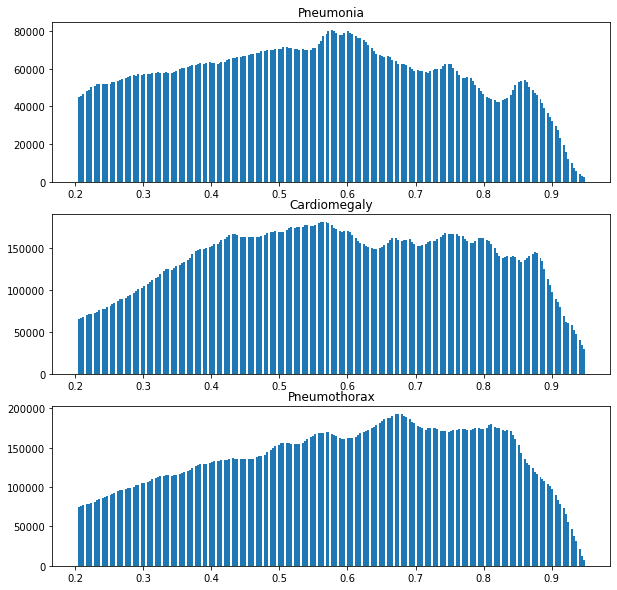

In [93]:
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)

i = 0
for disease in ['Pneumonia', 'Cardiomegaly','Pneumothorax']:
    # set the subplot position
    sub = fig.add_subplot(3, 1, i+1)
    sub.set_title(disease)
    # plot the histogram
    plt.hist(all_dis_dic[disease], bins = 256)
    # increase the index by 1
    i += 1

        
plt.show()

The overall shape is quite similar between Pneumonia and Cardiomegaly, though Pneumonia seems to have more of a slope and a more distinct small peak around 0.85. But overall Pneumonia and Cardiomegaly seem to be easy to misdiagnose between them.

Whereas, Pneumothorax seems to be different enough to not cause problem since its main peak is different enough.

Pneumonia has a peak around **0.56**

Cardiomegaly has a peak around **0.56**

Pneumothorax has a peak around **0.67**